In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import kagglehub
import os
import warnings
warnings.filterwarnings('ignore')

# Download dataset
print("Downloading dataset...")
path = kagglehub.dataset_download("diishasiing/revenue-for-cab-drivers")
print("Path to dataset files:", path)

# Find and load the CSV file
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
file_path = os.path.join(path, csv_files[0])
print(f"Loading data from: {file_path}")
df = pd.read_csv(file_path)
print(f"Original dataset shape: {df.shape}")

Path to dataset files: /Users/maevevas/.cache/kagglehub/datasets/diishasiing/revenue-for-cab-drivers/versions/1
Loading data from: /Users/maevevas/.cache/kagglehub/datasets/diishasiing/revenue-for-cab-drivers/versions/1/data.csv
Original dataset shape: (6405008, 18)


In [3]:
# Drop unnecessary columns early
columns_to_drop = ['extra', 'payment_type', 'mta_tax', 'tip_amount', 
                  'tolls_amount', 'improvement_surcharge', 'congestion_surcharge']
df = df.drop(columns=columns_to_drop, errors='ignore')

# Handle missing values
df = df.dropna()
print(f"Shape after removing missing values: {df.shape}")

# Date conversions
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Calculate trip duration in minutes
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

Shape after removing missing values: (6339567, 11)


In [4]:
# Remove extreme values based on trip duration and distance
duration_q1 = df['trip_duration'].quantile(0.01)
duration_q3 = df['trip_duration'].quantile(0.99)
distance_q1 = df['trip_distance'].quantile(0.01)
distance_q3 = df['trip_distance'].quantile(0.99)

df = df[(df['trip_duration'] >= duration_q1) & 
        (df['trip_duration'] <= duration_q3) &
        (df['trip_distance'] >= distance_q1) & 
        (df['trip_distance'] <= distance_q3)]

# Remove invalid data
df = df[(df['trip_duration'] > 0) & (df['trip_distance'] > 0)]
print(f"Shape after outlier removal: {df.shape}")

Shape after outlier removal: (6141753, 12)


In [6]:
# Sample more data for better model performance
df = df.sample(n=50000, random_state=42) if len(df) > 50000 else df
print(f"Working with {df.shape[0]} records")


# Time features
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_day'] = df['tpep_pickup_datetime'].dt.day
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month
df['pickup_dayofweek'] = df['tpep_pickup_datetime'].dt.dayofweek
df['is_weekend'] = df['pickup_dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# Rush hours (typical morning and evening rush periods)
df['is_rush_hour'] = ((df['pickup_hour'] >= 7) & (df['pickup_hour'] <= 10) | 
                      (df['pickup_hour'] >= 16) & (df['pickup_hour'] <= 19)).astype(int)

# Night hours (when there might be less traffic but higher rates)
df['is_night'] = ((df['pickup_hour'] >= 22) | (df['pickup_hour'] <= 5)).astype(int)

# Average speed feature (miles per hour)
df['avg_speed'] = np.where(df['trip_duration'] > 0, 
                          df['trip_distance'] / (df['trip_duration']/60), 0)

# Remove any invalid speed records
df = df[(df['avg_speed'] > 0) & (df['avg_speed'] < 80)]  # Reasonable speed range

# Create location clusters based on frequency
for col in ['PULocationID', 'DOLocationID']:
    location_counts = df[col].value_counts()
    frequent_locations = location_counts[location_counts > 100].index.tolist()
    df[f'{col}_frequent'] = df[col].apply(lambda x: 1 if x in frequent_locations else 0)

Working with 49998 records


In [7]:
# Prepare data for model
feature_cols = [
    'trip_distance', 'passenger_count', 'pickup_hour', 'pickup_day', 
    'pickup_month', 'pickup_dayofweek', 'is_weekend', 'is_rush_hour', 
    'is_night', 'avg_speed', 'PULocationID', 'DOLocationID',
    'PULocationID_frequent', 'DOLocationID_frequent'
]

X = df[feature_cols]
y = df['trip_duration']

# Split data with a larger training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Model training with optimized parameters
print("\n=== Training Optimized Random Forest Model ===")
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)


Training set size: (42498, 14)
Test set size: (7500, 14)

=== Training Optimized Random Forest Model ===


RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [8]:
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n=== Model Performance ===")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")


=== Model Performance ===
Mean Squared Error: 3.6146
Root Mean Squared Error: 1.9012
Mean Absolute Error: 1.1738
R² Score: 0.9494


In [9]:
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n=== Top 10 Most Important Features ===")
print(feature_importance.head(10))


=== Top 10 Most Important Features ===
                  Feature  Importance
0           trip_distance    0.683362
9               avg_speed    0.155319
10           PULocationID    0.038867
13  DOLocationID_frequent    0.034691
11           DOLocationID    0.028778
2             pickup_hour    0.021783
3              pickup_day    0.010813
5        pickup_dayofweek    0.006785
8                is_night    0.006785
12  PULocationID_frequent    0.004298


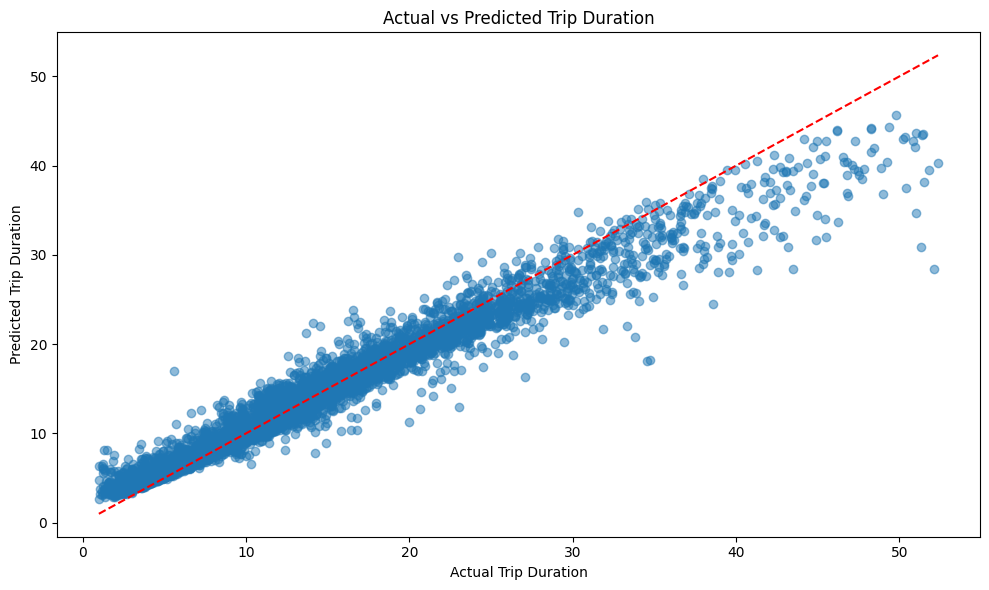

In [10]:
 plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Trip Duration')
plt.ylabel('Predicted Trip Duration')
plt.title('Actual vs Predicted Trip Duration')
plt.tight_layout()
plt.show()